In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.utils import img_to_array, load_img
from keras.utils import to_categorical
from timeit import default_timer as timer

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.8 from "/Users/caitlinchen/Desktop/NeuromorphicComputing/.venv/bin/python"
  * The NumPy version is: "1.24.3"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: No module named 'numpy.core._multiarray_umath'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


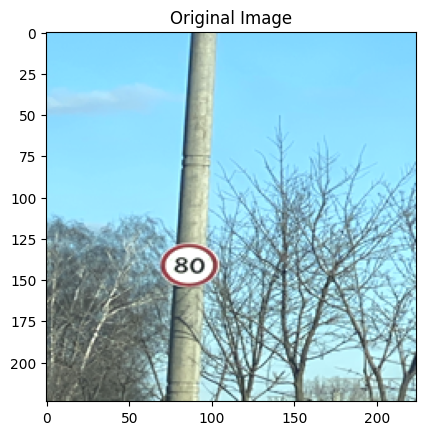

In [44]:
# Path to the directory containing images and annotations
data_path = '/Users/caitlinchen/Desktop/cmps4020/kaggle2'

#Create Images and Labels folders
image_folder = os.path.join(data_path, 'images')
labels_folder = os.path.join(data_path, 'annotations')

# Lists to store features (X) and labels (y)
X = []
y = []

for image_file in os.listdir(image_folder):
    # Load Image
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path).convert('RGB')
    #image = load_img(image_path, target_size=(224, 224))
    image = image.resize((224, 224))
    image_array = img_to_array(image)

    X.append(image_array)

    # Extract corresponding label from the XML annotation
    label_file = os.path.join(labels_folder, image_file.replace('.png', '.xml'))
    tree = ET.parse(label_file)
    root = tree.getroot()
    class_label = root.find('.//object/name').text
    if class_label == 'speedlimit':
        class_label = 0
    elif class_label == 'stop':
        class_label = 1
    elif class_label == 'crosswalk':
        class_label = 2
    elif class_label == 'trafficlight':
        class_label = 3
    y.append(class_label)

# Converting lists to numpy arrays
X = np.array(X)
y = np.array(y)

image1 = X[1]/225
plt.imshow(image1)  # To change [-1, 1] to [0,1]
plt.title('Original Image')
plt.show()

pre_processed_X = []
for image in X:
  pre_processed_image = keras.applications.vgg16.preprocess_input(image)
  pre_processed_X.append(pre_processed_image)



In [45]:
decode_predictions = tf.keras.applications.vgg16.decode_predictions
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [46]:
#load pre-trained model
model = VGG16(weights='imagenet', include_top=False, classes = 4, input_shape=(224, 224, 3))
x = model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(4, activation='softmax')(x)  # Output layer

model = Model(inputs=model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
#visualize perturbed images
image = pre_processed_X[1]/50
print(image.shape)
print(model.input_shape)
print()

(224, 224, 3)
(None, 224, 224, 3)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


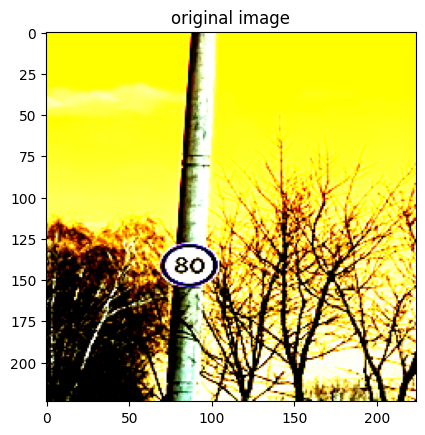

In [48]:
#image1 = Image.open('/Users/caitlinchen/Desktop/cmps4020/kaggle2/images/road107.png')
plt.figure()
plt.imshow(image)  # To change [-1, 1] to [0,1]
plt.title('original image')
plt.show()

In [49]:
#create adversarial image

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

1/1 [==============================] - 0s 430ms/step
LABEL:  (1, 4)
IMG:  (1, 224, 224, 3)


Text(0.5, 1.0, 'Noise')

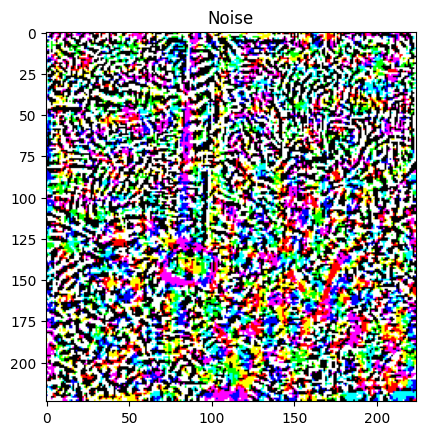

In [50]:
image = np.expand_dims(image1, axis=0)
image_probs = model.predict(image)
image = tf.convert_to_tensor(image)
index = 1
label = tf.one_hot(index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
print("LABEL: ", label.shape)
print("IMG: ", image.shape)

perturbation = create_adversarial_pattern(image, label)
plt.imshow(perturbation[0] * 0.5 + 0.5);
plt.title('Noise')

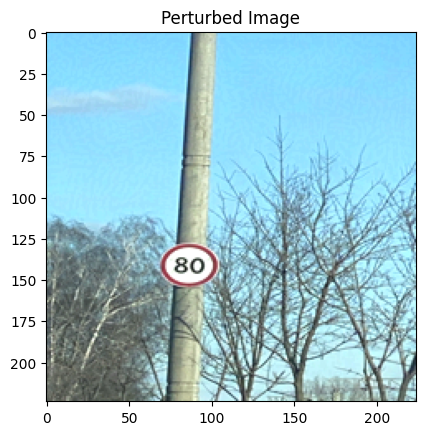

In [51]:
def display_images(image, description):
  plt.figure()
  plt.imshow(image[0])
  plt.title('Perturbed Image')
  plt.show()

eps = 0.01
adv_x = image1 + (perturbation * eps)
adv_x = tf.clip_by_value(adv_x, -1, 1)
display_images(adv_x, eps)


In [52]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)


In [1]:
num_classes = 4  # Assuming you have 4 classes

# Initialize lists to store adversarial images and labels
ad_X_train = []
ad_y_train = []

ad_X_test = []
ad_y_test = []

# Define the number of adversarial images per class
num_adversarial_per_class = 10

for class_label in range(num_classes):
    # Filter the training data by class label
    class_indices = np.where(y_train == class_label)[0]
    class_samples = X_train[class_indices]
    class_labels = y_train_encoded[class_indices]

    # Generate adversarial images for a certain number of samples from this class
    for i in range(min(num_adversarial_per_class, len(class_samples))):
        image = class_samples[i]
        label = class_labels[i]

        # Convert image to tensor
        image = pre_processed_X[i]
        image = np.expand_dims(image, axis=0)
        image_tf = tf.convert_to_tensor(image)

        # Define the label for the adversarial image
        index = 1 
        label = tf.one_hot(index, num_classes)
        label = tf.reshape(label, (1, num_classes))

        # Generate adversarial image
        perturbation = create_adversarial_pattern(image_tf, label)
        adversarial_image = image + (perturbation * 0.5 * 0.5)

        # Append the adversarial image and label to the lists
        if i < 5:
            ad_X_train.append(adversarial_image)
            ad_y_train.append(class_label)
        else:
            ad_X_test.append(adversarial_image)
            ad_y_test.append(class_label) 

# Convert lists to numpy arrays
ad_X_train = np.array(ad_X_train)
ad_y_train = np.array(ad_y_train)
ad_y_train_encoded = to_categorical(y_train, num_classes)

ad_X_test = np.array(ad_X_test)
ad_y_test = np.array(ad_X_test)
ad_y_test_encoded = to_categorical(y_test, num_classes)


NameError: name 'np' is not defined

In [78]:
#Test Accuracy of Model on Adversarial Images
start = timer()
print("Starting Timer")
accuracy = model.evaluate(ad_X_test, ad_y_test_encoded)[1]
end = timer()
print("Time to Run: ", (end - start))
print(f"Accuracy: {accuracy}")

Starting Timer


NameError: name 'ad_y_test_encoded' is not defined

In [54]:
start = timer()
print("Starting Timer")
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32)
end = timer()
print("Time to Run: ", (end - start))

'start = timer()\nprint("Starting Timer")\nmodel.fit(X_train, y_train_encoded, epochs=10, batch_size=32)\nend = timer()\nprint("Time to Run: ", (end - start))'

In [55]:
start = timer()
print("Starting Timer")
accuracy = model.evaluate(X_test, y_test_encoded)[1]
end = timer()
print("Time to Run: ", (end - start))
print(f"Accuracy: {accuracy}")

Starting Timer
6/6 [==============================] - 39s 6s/step - loss: 1.8570 - accuracy: 0.3864
Time to Run:  39.46347482400006
Accuracy: 0.3863636255264282


In [65]:
"""adversarial_X_train = []
adversarial_y_train = []

num_perturbed = 20
for i in range(num_perturbed):
    #image = np.expand_dims(image, axis=0)
    image = pre_processed_X[i]
    image = np.expand_dims(image, axis=0)
    image_probs = model.predict(image)
    image_tf = tf.convert_to_tensor(image)
    index = 1
    label = tf.one_hot(index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    perturbation = create_adversarial_pattern(image_tf, label)
    adversarial_image = image + (perturbation * 0.5 * 0.5)
    adversarial_X_train.append(adversarial_image)
    adversarial_y_train.append(y_train[i])

adversarial_X_train = np.array(adversarial_X_train)
adversarial_y_train = np.array(adversarial_y_train)"""

ad_X_train = np.squeeze(ad_X_train, axis=1)
ad_y_train_encoded = to_categorical(ad_y_train, num_classes)

X_train_ad = np.concatenate((X_train, ad_X_train), axis = 0)
y_train_ad = np.concatenate((y_train_encoded, ad_y_train_encoded), axis = 0)
aug_X_train = shuffle(X_train_ad)
aug_y_train = shuffle(y_train_ad)

1/1 [==============================] - 0s 193ms/step
X_train:  [[[ 11.32       60.221      86.061    ]
  [ 14.32       59.221      88.061    ]
  [ 13.32       58.221      86.061    ]
  ...
  [ 40.32       75.221      95.061    ]
  [ 42.32       78.221      98.061    ]
  [ 41.32       78.221      97.061    ]]

 [[ 10.32       55.221      80.061    ]
  [ 11.32       56.221      82.061    ]
  [ 11.32       57.221      82.061    ]
  ...
  [ 34.32       73.221      94.061    ]
  [ 35.32       74.221      94.061    ]
  [ 39.32       77.221      97.061    ]]

 [[  7.3199997  55.221      79.061    ]
  [  8.32       55.221      80.061    ]
  [ 11.32       57.221      83.061    ]
  ...
  [ 29.32       71.221      93.061    ]
  [ 30.32       72.221      93.061    ]
  [ 31.32       72.221      93.061    ]]

 ...

 [[-60.68      -26.779       2.060997 ]
  [-60.68      -26.779       2.060997 ]
  [-58.68      -24.779       5.060997 ]
  ...
  [-55.68      -29.779      -5.939003 ]
  [-54.68      -28.77

In [66]:
print("Fitting with Perturbed Images")
start = timer()
print("Starting Timer")
model.fit(aug_X_train, aug_y_train, epochs=10, batch_size=32)
end = timer()
print("Time to Run: ", (end - start))

Fitting with Perturbed Images
Starting Timer
Epoch 1/10
23/23 [==============================] - 431s 18s/step - loss: 4.5722 - accuracy: 0.6408
Epoch 2/10
23/23 [==============================] - 404s 18s/step - loss: 0.9479 - accuracy: 0.7434
Epoch 3/10
23/23 [==============================] - 339s 14s/step - loss: 0.8697 - accuracy: 0.7434
Epoch 4/10
23/23 [==============================] - 342s 15s/step - loss: 0.8573 - accuracy: 0.7434
Epoch 5/10
23/23 [==============================] - 333s 14s/step - loss: 0.8589 - accuracy: 0.7434
Epoch 6/10
23/23 [==============================] - 335s 15s/step - loss: 0.8630 - accuracy: 0.7434
Epoch 7/10
23/23 [==============================] - 324s 14s/step - loss: 0.8594 - accuracy: 0.7434
Epoch 8/10
23/23 [==============================] - 332s 14s/step - loss: 0.8432 - accuracy: 0.7434
Epoch 9/10
23/23 [==============================] - 331s 14s/step - loss: 0.8610 - accuracy: 0.7434
Epoch 10/10
23/23 [==============================] - 32

In [67]:
print("Accuracy after Training with Perturbed Images")
start = timer()
print("Starting Timer")
accuracy = model.evaluate(X_test, y_test_encoded)[1]
end = timer()
print("Time to Run: ", (end - start))
print(f"Accuracy: {accuracy}")

Accuracy after Training with Perturbed Images
Starting Timer
6/6 [==============================] - 25s 4s/step - loss: 0.8764 - accuracy: 0.7557
Time to Run:  25.452595097000085
Accuracy: 0.7556818127632141
